# Chapter 6: Learning best practices for model evaluation and hyperparameter tuning

## Streamlining workflows with pipelines

Piplines allow for fitting a model usign an arbitrary number of transformations steps

### reading in the data:

1. get the data

In [1]:
import pandas as pd
df = pd.read_csv('wdbc.data')

2. use label encoder to transform the data into numerics

(M = malignant tumors)

In [2]:
from sklearn.preprocessing import LabelEncoder 
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0])

3. split the data

In [4]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

### Now apply the transforms with pipeline

Data will need to be standardized.  And, to reduce the 30 features, PCA will be used.

In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline #this will make the pipeline

Make a pipeline using the scaler, PCA dimensionality reductiona, and then apply the model. `make_pipeline` will take an arbitrary number of transformer objects which are followed by an estimator. The pipeline object then acts like a "meta-estimator".

In [6]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())

`pipe_lr` will now act like a model object for the data:

In [7]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.930


The `pipeline.fit()` will be used with training data and the `pipeline.predict()` is used with test data.  The training data passes through the `fit` and `transform` methods of the transformers/estimators, whereas the test data only passes through the `transform` methods.

## Using k-fold cross validation to assess model performance

### Holdout method

*Holdout cross-validation* is when a test set is held out to test a model on unseen data. However, this can be extended to holding out a validation set on which to tune hyperparameters for a model, and to help with model selection. Then the final model and hyperparameters are selected and used to predict on the test data set.  However, models might be sensitive to how the train/validate/test are partitioned.

### K-fold cross validation

*K-fold cross validation* is a more robust way of cross validation. The training set is subset into $k$ folds without replacement, and $k - 1$ are training folds with the last fold as the test fold which is used for performance evaluation. This is repeated $k$ times for $k$ models.

Each model is then hyperparameter tuned to a single fold of the $k-1$ train folds and tested on the test fold. Once hyperparameters are tuned, the model is trained on the entire train set and evaluated on the test set.  Then all of the $k$ models (having been hyperparameter tuned) can be evaluated against the test set.

Estimated performance can be computed for the $k$ folds by:
$$
    E = \sum^k_{i=0} \frac{E_i}{k}
$$
Where $E_i$ is the evaluation metric for each of the models.

K-fold validation uses all the datapoints, unlike the holdout method.  However, an efficient choice of $k$ should be chosen; a good standard is 10.

(Note: each model gets a single fold to train on.  Only the final model is trained on the entire train fold.  Before the final model, each model is trained on $\frac{1}{k}$ of the data).

Smaller datasets can benefit from a larger $k$, so that more of the data is used in each iteration.  This increases runtime and variance. Larger datasets  benefit from a smaller $k$ because in decreases runtime.

*Leave one out cross-validation* : set $k=n$, and leave a single record out to predict.  Every iteration, a different record is left out to predict.  This is useful for small datasets.

*Stratified k-fold cross-validation* : target labels are stratified in the training and test sets. Use scikit-learn's `StratifiedKFold`. 

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train) 
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test]) 
    scores.append(score)
    print(f"Fold: {k+1:02d}, Class distr.: {np.bincount(y_train[train])}, Acc.: {score:.3f}")

Fold: 01, Class distr.: [256 152], Acc.: 0.913
Fold: 02, Class distr.: [256 152], Acc.: 0.935
Fold: 03, Class distr.: [256 152], Acc.: 0.957
Fold: 04, Class distr.: [256 152], Acc.: 0.891
Fold: 05, Class distr.: [257 152], Acc.: 0.978
Fold: 06, Class distr.: [257 152], Acc.: 0.978
Fold: 07, Class distr.: [257 152], Acc.: 0.978
Fold: 08, Class distr.: [257 152], Acc.: 0.911
Fold: 09, Class distr.: [257 152], Acc.: 0.933
Fold: 10, Class distr.: [256 153], Acc.: 0.978


- `n_splits` = $k$
- `.split()` is where the target variable is defined
- Then the splits are looped over for training and scoring.

In [9]:
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


CV accuracy: 0.945 +/- 0.031


The average metrics are calculated. `cross_val_score` can also be used, where `cv` is the number of splits.  Note that `n_jobs` will distribute the computation across multiple CPUs.

In [10]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy scores: [0.91304348 0.93478261 0.95652174 0.89130435 0.97777778 0.97777778
 0.97777778 0.91111111 0.93333333 0.97777778]
CV accuracy: 0.945 +/- 0.031


## Debugging learning algorithms with a learning and validation curves

### Diagnosing bias and variance problems with learning curves
The train and validate accuracy can be plotted as a function of number of training samples to determine the optimal variance and bias trade-off; this is called a *learning curve*. Recall that a model will high bias (underfitting) can be made better by:
- increasing model parameters
- collecting and constructing new features
- decreasing regularization strength
Whereas a model with high variance (overfitting) can be made better by:
- collecting more training data
- reducing model complexity
- increasing regularization strength
If regularization is not possible, using dimensionality reduction techniques can improve a model; either feature selection, or feature extraction.

Scikit-learn has the `learning_curve` method to help analyze these.

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
#max_iter = 10_000 prevents convergence issues
pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',max_iter=10000))
train_sizes, train_scores, test_scores = \
    learning_curve( #this is the funciton we're interested in
        estimator=pipe_lr,
        X=X_train,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10), #Controls the number of training samples used to make the curves
        cv=10, #by default the function uses k-fold cross validation via the cv parameter
        n_jobs=1
    )
#now calculate the mu and sigma for the two sets.
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1) 
test_mean = np.mean(test_scores, axis=1) 
test_std = np.std(test_scores, axis=1)

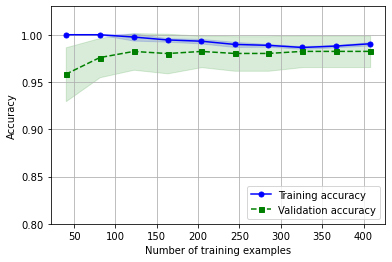

In [12]:
plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5, label='Training accuracy') 
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue') 
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='Validation accuracy') 
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples') 
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

### Addressing over- and under-fitting with validation curves

*Validation curves* plot the accuracy in terms of a model parameter.  For example, below the `C` (inverse regularization) is plotted.  The graph shows a high regularization strength leads to model underfitting, but a low regularization strength leads to overfitting.  Ideal is around $0.01$.

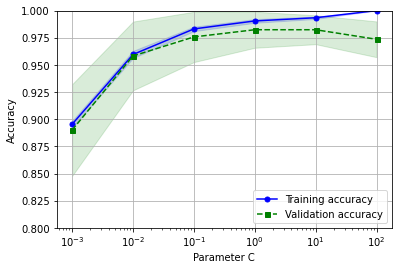

In [13]:
from sklearn.model_selection import validation_curve 
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
train_scores, test_scores = validation_curve( 
    estimator=pipe_lr, 
    X=X_train, 
    y=y_train, 
    param_name='logisticregression__C', #access the inverse regularization
    param_range=param_range, #C values to loop over
    cv=10 #k-fold with k=10
    )
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1) 
test_mean = np.mean(test_scores, axis=1) 
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue') 
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy') 
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

## Finetuning models via grid search

*Grid search* finds the optimal hyperparameters by taking the product of lists of paramters and returning the metric for each set.

This is done in scikit-learn via the following:
1. make a parameter range
2. make a parameter grid
3. call `GridSearchCV`

Note: this is a brute force technique.  It checks every single combination of parameters; therefore it is computationaly heavy.  This can be sped up by using the `n_jobs` parameter.

In [14]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1)) 
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] #a range of parameters
param_grid = [ #used to tune the various parameters
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]
gs = GridSearchCV(estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10, #gird search uses k-fold. set k=10
    refit=True,
    n_jobs=None #uses all the processors to speed up the search if set to -1
)
gs = gs.fit(X_train, y_train) #fit the gridsearch
#get the best scores and the best combination of parameters
print(gs.best_score_)
print(gs.best_params_)

0.9779710144927536
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


Finally, the `best_estimator_` attribute can be used to fit a mode and predicitons are made on a test set.  Note: there is also a `refit` parameter that will use the whole training set is set to `True` (this is the default).

In [15]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.965


## Hyperparameter tuning with randomized search

*Randomized search* takes a random sample of the model parameters range.  This allows for a wider range od values to be tried out. By randomized across a range instead of using a grid (product of discrete values), sometimes better hyperparameters are found if the parameter space is sparse.

Scikit-learn used `RandomizedSearchCV`.  Note in the example below, the best parameter for `C` is a more specific value that improves the score by almost 2 points.

In [16]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
param_range = loguniform(0.0001, 1000.0) # a continuous range is drawn from
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]
rs = RandomizedSearchCV(estimator=pipe_svc,
    param_distributions=param_grid,
    scoring='accuracy',
    refit=True,
    n_iter=20,
    cv=10,
    random_state=1,
    n_jobs=-1)
rs = rs.fit(X_train, y_train) 
print(rs.best_score_)
print(rs.best_params_)

0.9823671497584542
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


## Resource efficient hyperparameter tuning search with successive halving

Implemented via the `HalvingRandomSearchCV` in scikit-learn. It uses the following steps:
1. Draw candidate configs via random sampling
2. Train a model with limited resources (example: a subset of `train`)
3. Discard the bottom half based on predictive performance
4. Repeat 2 and below, but with more resources for training.

Steps are repeated until only one hyperparameter configuration remains.

In [19]:
#halving is experimental so it neeeds to be enabled
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples', #n_samples means training set size will be varied in halvings
    factor=1.5, #about 66% of configuration will make it to the next iteration
    random_state=1,
    n_jobs=None
)
hs = hs.fit(X_train, y_train) 
print(hs.best_score_)
print(hs.best_params_)
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

0.9735294117647058
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}
Test accuracy: 0.930


## Algorithm selection with nested cross-validation

*Nested cross-validation* : Data is split into $k$-fold train and test folds for $k$ estimators; the train folds are then split again for each estimator's hyperparameter tuning. This is sometimes called $5 \times 2$ *cross validation* when the first split uses $k=5$ folds and the second split uses $k=2$ folds.

In [20]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]
#make a grid search with k=2
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)
#now use the cross validation by the gridsearch object
#note that the folds are now k=5
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.978 +/- 0.012


In [ ]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
... estimator=DecisionTreeClassifier(random_state=0),
... param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring='accuracy',
... cv=2
... )
>>> scores = cross_val_score(gs, X_train, y_train,
... scoring='accuracy', cv=5)
>>> print(f'CV accuracy: {np.mean(scores):.3f} '
... f'+/- {np.std(scores):.3f}')